In [1]:
#---------------------------------
#Image Processing and Machine Vision
#Team Inception
#Retinal Vessel Segmentation
#---------------------------------

In [2]:
!pip install -U -q segmentation-models --user

from PIL import Image
import numpy as np 
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf


root = '../input/retinal-vessel-segmentation'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [3]:
input_data = os.path.join(root, 'DRIVE/training/images')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join(root, 'DRIVE/training/1st_manual')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-31:], "|", target_path[-34:])

Number of samples: 20 20
training/images/21_training.tif | training/1st_manual/21_manual1.gif
training/images/22_training.tif | training/1st_manual/22_manual1.gif
training/images/23_training.tif | training/1st_manual/23_manual1.gif
training/images/24_training.tif | training/1st_manual/24_manual1.gif
training/images/25_training.tif | training/1st_manual/25_manual1.gif
training/images/26_training.tif | training/1st_manual/26_manual1.gif
training/images/27_training.tif | training/1st_manual/27_manual1.gif
training/images/28_training.tif | training/1st_manual/28_manual1.gif
training/images/29_training.tif | training/1st_manual/29_manual1.gif
training/images/30_training.tif | training/1st_manual/30_manual1.gif


In [4]:
IMAGE_SIZE = 512
BATCH_SIZE = 12

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.io.decode_gif(image) # out: (1, h, w, 3)
        image = tf.squeeze(image) # out: (h, w, 3)
        image = tf.image.rgb_to_grayscale(image) # out: (h, w, 1)
        image = tf.divide(image, 128)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)
    else:
        image = tfio.experimental.image.decode_tiff(image) # out: (h, w, 4)
        image = image[:,:,:3] # out: (h, w, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.
    return image

def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images) 
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

(12, 512, 512, 3) (12, 512, 512, 1)
0 1
[0 1]


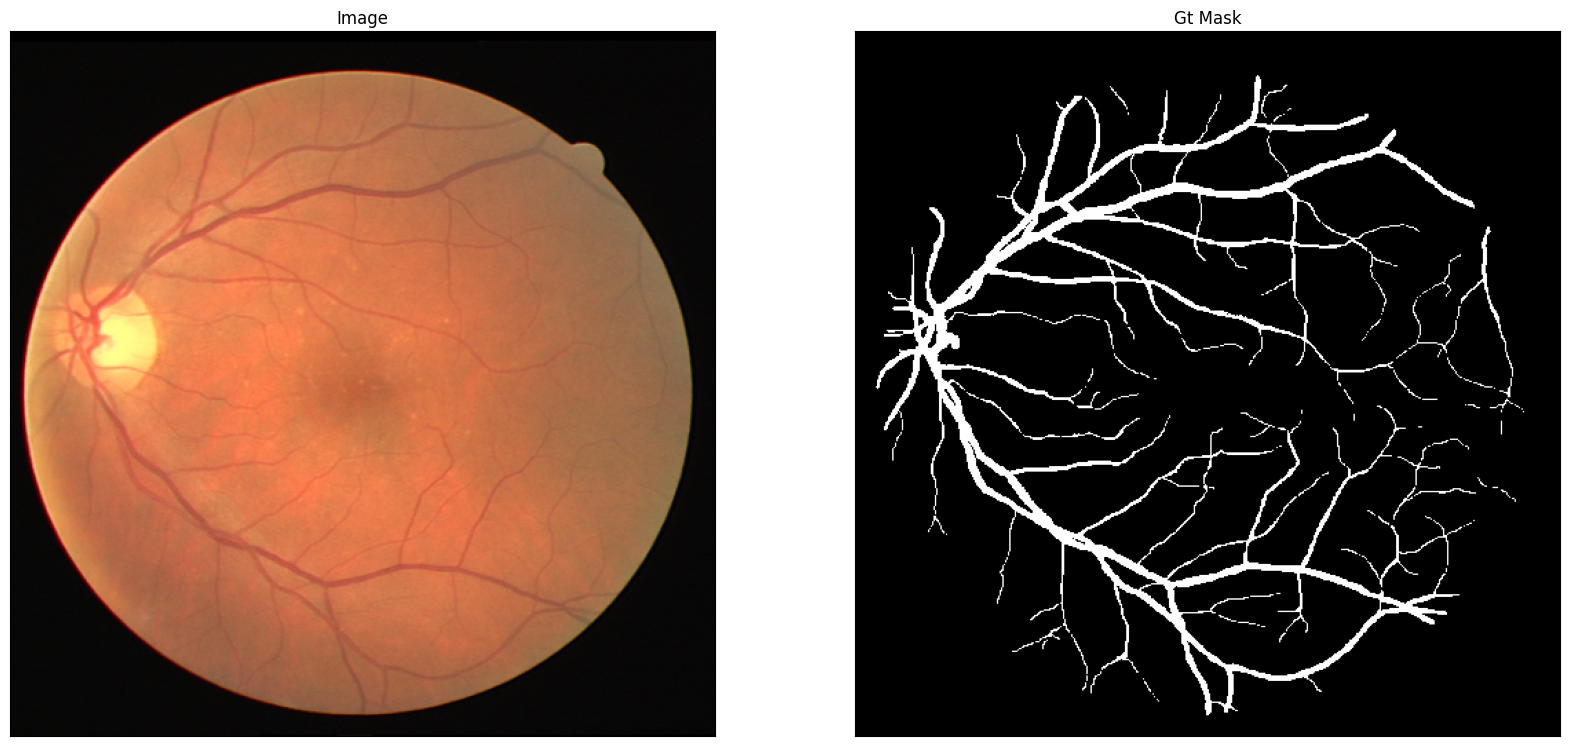

In [6]:
image, mask = next(iter(train_dataset.take(1))) 
print(image.shape, mask.shape)

for (img, msk) in zip(image[:1], mask[:1]):
    print(mask.numpy().min(), mask.numpy().max())
    print(np.unique(mask.numpy()))
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(),
    )

In [7]:
from tensorflow import keras 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb0'
n_classes  = 1 
activation = 'sigmoid' 
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
# model.summary(line_length=110)

16804768/16804768 [==============================] - 0s 0us/step


In [8]:
# custom model

In [9]:
'''import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Conv2D, Multiply, concatenate

class CustomUnetBase:
    def __init__(self, *args, dropout_rate=0.5, **kwargs):
        self.dropout_rate = dropout_rate

    def structured_dropout_conv_block(self, x, filters, kernel_size=(3, 3)):
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = Dropout(self.dropout_rate)(x)
        return x

    def spatial_attention_module(self, x):
        max_pooling = GlobalMaxPooling2D()(x)
        avg_pooling = GlobalAveragePooling2D()(x)
        combined_pooling = concatenate([max_pooling, avg_pooling], axis=-1)

        attention = Conv2D(1, (1, 1), activation='sigmoid')(combined_pooling)

        return Multiply()([x, attention])

class CustomUnet(tf.keras.Model):
    def __init__(self, *args, dropout_rate=0.5, **kwargs):
        super(CustomUnet, self).__init__()
        self.custom_unet_base = CustomUnetBase(*args, dropout_rate=dropout_rate, **kwargs)
        kwargs.pop('dropout_rate', None)  # Remove dropout_rate from kwargs
        self.unet_model = sm.Unet(*args, **kwargs)

    def decoder_block(self, x, skip, filters, block_number):
        x = self.unet_model.decoder_block(x, skip, filters, block_number)
        x = self.custom_unet_base.structured_dropout_conv_block(x, filters)
        x = self.custom_unet_base.spatial_attention_module(x)

        # Skip connection
        skip = Conv2D(filters, (1, 1), padding='same')(skip)
        x = concatenate([x, skip], axis=-1)

        return x

    def call(self, inputs):
        return self.unet_model(inputs)

# Clear previous session
tf.keras.backend.clear_session()

# Create the custom Unet model
model = CustomUnet('efficientnetb0', classes=1, activation='sigmoid', dropout_rate=0.5)
model.build((None, None, None, 3))  # Build the model with a specific input shape
model.summary()'''

"import segmentation_models as sm\nimport tensorflow as tf\nfrom tensorflow.keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Conv2D, Multiply, concatenate\n\nclass CustomUnetBase:\n    def __init__(self, *args, dropout_rate=0.5, **kwargs):\n        self.dropout_rate = dropout_rate\n\n    def structured_dropout_conv_block(self, x, filters, kernel_size=(3, 3)):\n        x = Conv2D(filters, kernel_size, padding='same')(x)\n        x = BatchNormalization()(x)\n        x = tf.keras.layers.ReLU()(x)\n        x = Dropout(self.dropout_rate)(x)\n        return x\n\n    def spatial_attention_module(self, x):\n        max_pooling = GlobalMaxPooling2D()(x)\n        avg_pooling = GlobalAveragePooling2D()(x)\n        combined_pooling = concatenate([max_pooling, avg_pooling], axis=-1)\n\n        attention = Conv2D(1, (1, 1), activation='sigmoid')(combined_pooling)\n\n        return Multiply()([x, attention])\n\nclass CustomUnet(tf.keras.Model):\n    def __i

In [10]:
from tensorflow import keras
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=10):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
        self.f1_scores = []
        self.mcc_scores = []
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            f1 = logs.get('f1_metric', 0.0)
            mcc = logs.get('mcc_metric', 0.0)
            self.f1_scores.append(f1)
            self.mcc_scores.append(mcc)
            if epoch and epoch % (self.epoch_interval*5) == 0:
                self.show_predictions(self.dataset)
                print ('\n Sample Output after {} epochs\n'.format(epoch+1))

In [11]:
'''# define optomizer
optim = keras.optimizers.Adam(0.0001)
bce   = keras.losses.BinaryCrossentropy()
metrics = ["accuracy"]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, bce, metrics)

model.fit(
    train_dataset, 
    callbacks=[DisplayCallback(train_dataset)],
    epochs=200
)'''

'# define optomizer\noptim = keras.optimizers.Adam(0.0001)\nbce   = keras.losses.BinaryCrossentropy()\nmetrics = ["accuracy"]\n\n# compile keras model with defined optimozer, loss and metrics\nmodel.compile(optim, bce, metrics)\n\nmodel.fit(\n    train_dataset, \n    callbacks=[DisplayCallback(train_dataset)],\n    epochs=200\n)'

Epoch 1/420
2/2 [==============================] - 69s 6s/step - loss: 0.6754 - accuracy: 0.6209 - f1_metric: 0.1339 - mcc_metric: -0.0078
Epoch 2/420
2/2 [==============================] - 1s 436ms/step - loss: 0.6417 - accuracy: 0.6644 - f1_metric: 0.1733 - mcc_metric: 0.0576
Epoch 3/420
2/2 [==============================] - 1s 435ms/step - loss: 0.6187 - accuracy: 0.6861 - f1_metric: 0.2042 - mcc_metric: 0.1050
Epoch 4/420
2/2 [==============================] - 1s 436ms/step - loss: 0.6007 - accuracy: 0.7041 - f1_metric: 0.2305 - mcc_metric: 0.1441
Epoch 5/420
2/2 [==============================] - 1s 423ms/step - loss: 0.5847 - accuracy: 0.7226 - f1_metric: 0.2533 - mcc_metric: 0.1764
Epoch 6/420
2/2 [==============================] - 1s 438ms/step - loss: 0.5699 - accuracy: 0.7415 - f1_metric: 0.2752 - mcc_metric: 0.2059
Epoch 7/420
2/2 [==============================] - 1s 436ms/step - loss: 0.5559 - accuracy: 0.7607 - f1_metric: 0.2969 - mcc_metric: 0.2334
Epoch 8/420
2/2 [====

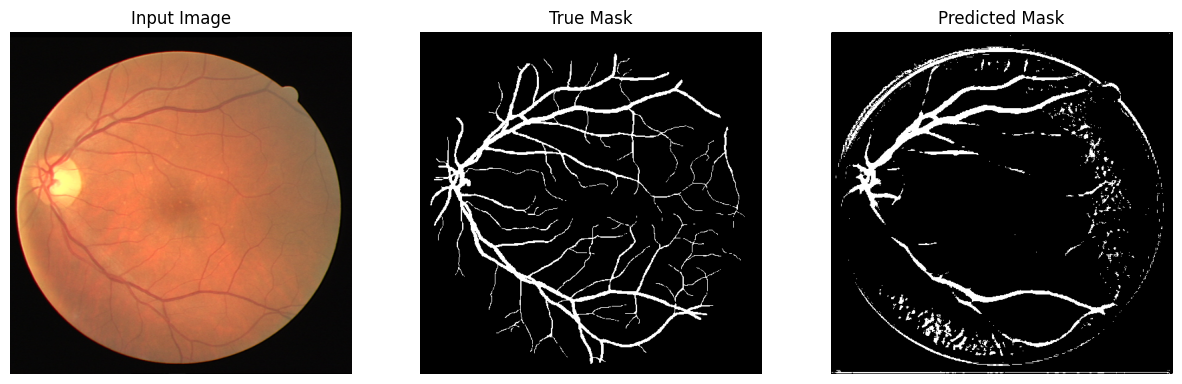


 Sample Output after 51 epochs

2/2 [==============================] - 4s 3s/step - loss: 0.2218 - accuracy: 0.9604 - f1_metric: 0.7677 - mcc_metric: 0.7458
Epoch 52/420
2/2 [==============================] - 1s 421ms/step - loss: 0.2189 - accuracy: 0.9611 - f1_metric: 0.7700 - mcc_metric: 0.7484
Epoch 53/420
2/2 [==============================] - 1s 437ms/step - loss: 0.2169 - accuracy: 0.9613 - f1_metric: 0.7703 - mcc_metric: 0.7489
Epoch 54/420
2/2 [==============================] - 1s 436ms/step - loss: 0.2140 - accuracy: 0.9619 - f1_metric: 0.7741 - mcc_metric: 0.7530
Epoch 55/420
2/2 [==============================] - 1s 435ms/step - loss: 0.2115 - accuracy: 0.9624 - f1_metric: 0.7771 - mcc_metric: 0.7564
Epoch 56/420
2/2 [==============================] - 1s 423ms/step - loss: 0.2096 - accuracy: 0.9626 - f1_metric: 0.7778 - mcc_metric: 0.7572
Epoch 57/420
2/2 [==============================] - 1s 452ms/step - loss: 0.2082 - accuracy: 0.9624 - f1_metric: 0.7768 - mcc_metric: 0.7

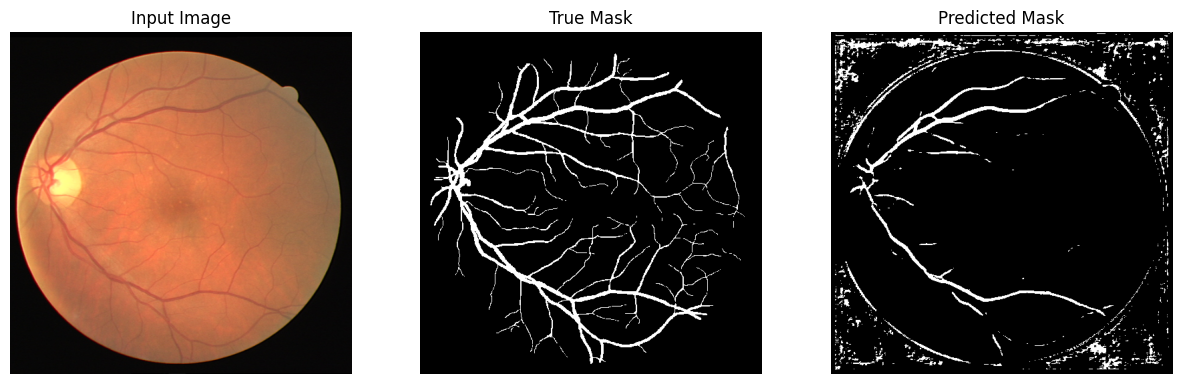


 Sample Output after 101 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.1499 - accuracy: 0.9701 - f1_metric: 0.8220 - mcc_metric: 0.8058
Epoch 102/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1483 - accuracy: 0.9707 - f1_metric: 0.8246 - mcc_metric: 0.8090
Epoch 103/420
2/2 [==============================] - 1s 435ms/step - loss: 0.1481 - accuracy: 0.9706 - f1_metric: 0.8237 - mcc_metric: 0.8081
Epoch 104/420
2/2 [==============================] - 1s 423ms/step - loss: 0.1466 - accuracy: 0.9710 - f1_metric: 0.8265 - mcc_metric: 0.8110
Epoch 105/420
2/2 [==============================] - 1s 439ms/step - loss: 0.1460 - accuracy: 0.9710 - f1_metric: 0.8269 - mcc_metric: 0.8113
Epoch 106/420
2/2 [==============================] - 1s 422ms/step - loss: 0.1458 - accuracy: 0.9709 - f1_metric: 0.8267 - mcc_metric: 0.8111
Epoch 107/420
2/2 [==============================] - 1s 435ms/step - loss: 0.1442 - accuracy: 0.9715 - f1_metric: 0.8293 - mcc_metr

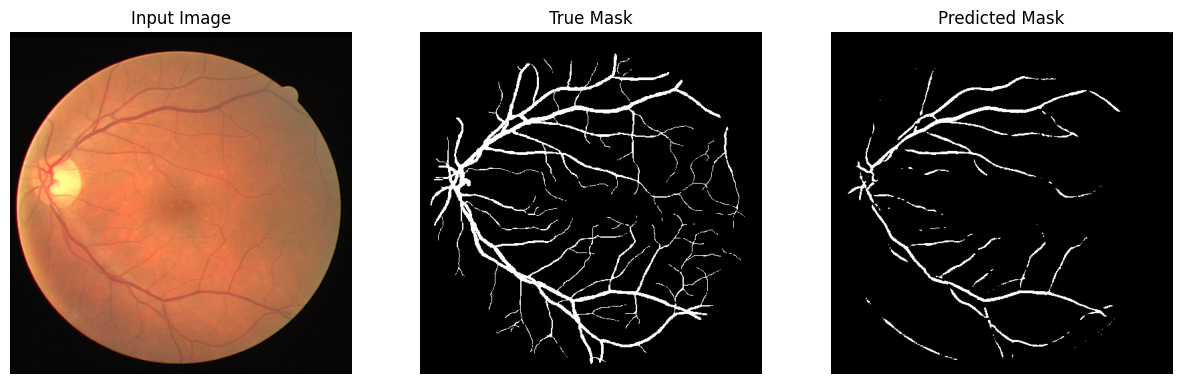


 Sample Output after 151 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.1175 - accuracy: 0.9758 - f1_metric: 0.8576 - mcc_metric: 0.8447
Epoch 152/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1173 - accuracy: 0.9756 - f1_metric: 0.8554 - mcc_metric: 0.8423
Epoch 153/420
2/2 [==============================] - 1s 435ms/step - loss: 0.1167 - accuracy: 0.9758 - f1_metric: 0.8571 - mcc_metric: 0.8441
Epoch 154/420
2/2 [==============================] - 1s 436ms/step - loss: 0.1170 - accuracy: 0.9755 - f1_metric: 0.8551 - mcc_metric: 0.8420
Epoch 155/420
2/2 [==============================] - 1s 421ms/step - loss: 0.1155 - accuracy: 0.9761 - f1_metric: 0.8592 - mcc_metric: 0.8464
Epoch 156/420
2/2 [==============================] - 1s 438ms/step - loss: 0.1152 - accuracy: 0.9759 - f1_metric: 0.8578 - mcc_metric: 0.8449
Epoch 157/420
2/2 [==============================] - 1s 435ms/step - loss: 0.1152 - accuracy: 0.9757 - f1_metric: 0.8565 - mcc_metr

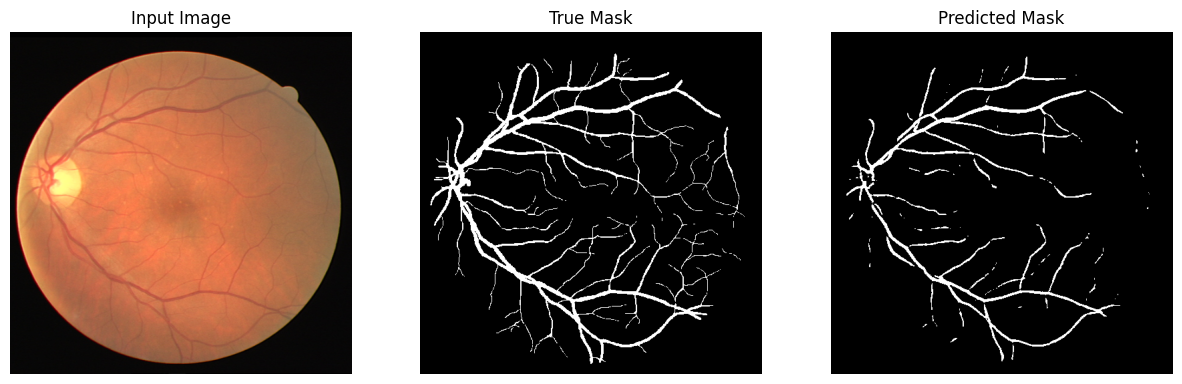


 Sample Output after 201 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0956 - accuracy: 0.9799 - f1_metric: 0.8822 - mcc_metric: 0.8714
Epoch 202/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0955 - accuracy: 0.9797 - f1_metric: 0.8813 - mcc_metric: 0.8705
Epoch 203/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0960 - accuracy: 0.9792 - f1_metric: 0.8776 - mcc_metric: 0.8665
Epoch 204/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0944 - accuracy: 0.9801 - f1_metric: 0.8840 - mcc_metric: 0.8733
Epoch 205/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0944 - accuracy: 0.9800 - f1_metric: 0.8828 - mcc_metric: 0.8722
Epoch 206/420
2/2 [==============================] - 1s 422ms/step - loss: 0.0943 - accuracy: 0.9798 - f1_metric: 0.8819 - mcc_metric: 0.8712
Epoch 207/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0940 - accuracy: 0.9799 - f1_metric: 0.8821 - mcc_metr

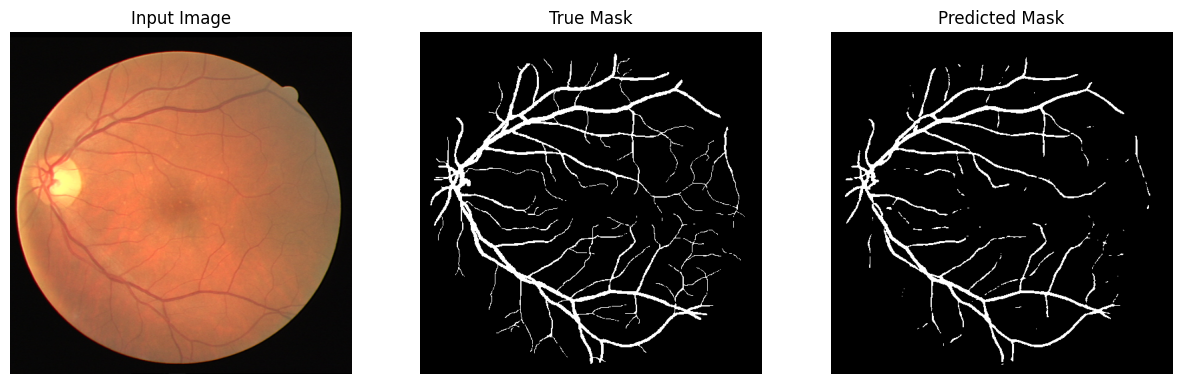


 Sample Output after 251 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0795 - accuracy: 0.9830 - f1_metric: 0.9009 - mcc_metric: 0.8918
Epoch 252/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0794 - accuracy: 0.9829 - f1_metric: 0.9010 - mcc_metric: 0.8920
Epoch 253/420
2/2 [==============================] - 1s 437ms/step - loss: 0.0788 - accuracy: 0.9831 - f1_metric: 0.9022 - mcc_metric: 0.8932
Epoch 254/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0788 - accuracy: 0.9830 - f1_metric: 0.9010 - mcc_metric: 0.8919
Epoch 255/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0787 - accuracy: 0.9830 - f1_metric: 0.9016 - mcc_metric: 0.8927
Epoch 256/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0779 - accuracy: 0.9834 - f1_metric: 0.9039 - mcc_metric: 0.8951
Epoch 257/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0785 - accuracy: 0.9828 - f1_metric: 0.8996 - mcc_metr

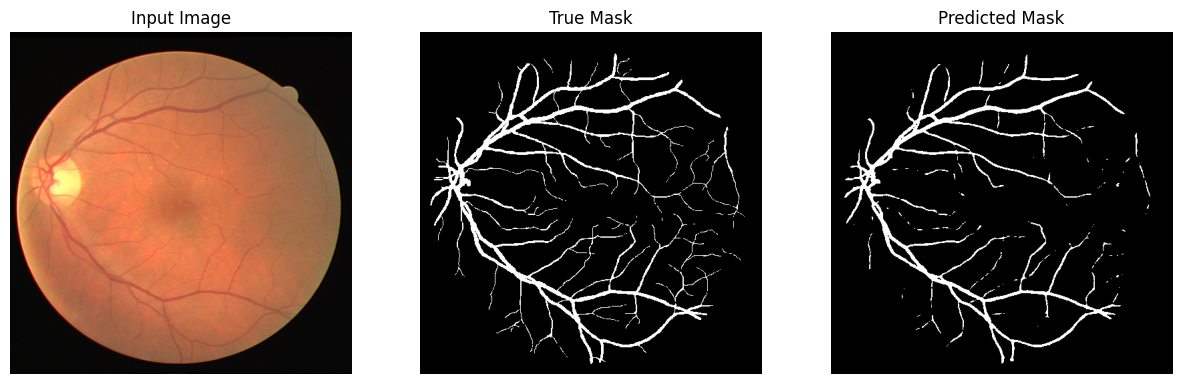


 Sample Output after 301 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0670 - accuracy: 0.9855 - f1_metric: 0.9161 - mcc_metric: 0.9084
Epoch 302/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0672 - accuracy: 0.9853 - f1_metric: 0.9149 - mcc_metric: 0.9070
Epoch 303/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0670 - accuracy: 0.9853 - f1_metric: 0.9159 - mcc_metric: 0.9082
Epoch 304/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0665 - accuracy: 0.9855 - f1_metric: 0.9166 - mcc_metric: 0.9089
Epoch 305/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0662 - accuracy: 0.9856 - f1_metric: 0.9171 - mcc_metric: 0.9094
Epoch 306/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0654 - accuracy: 0.9861 - f1_metric: 0.9202 - mcc_metric: 0.9129
Epoch 307/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0658 - accuracy: 0.9857 - f1_metric: 0.9177 - mcc_metr

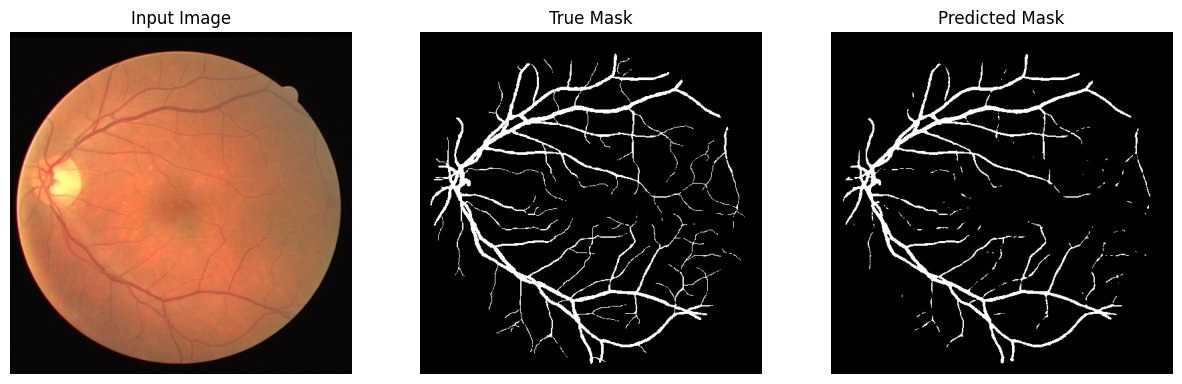


 Sample Output after 351 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0575 - accuracy: 0.9877 - f1_metric: 0.9297 - mcc_metric: 0.9232
Epoch 352/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0572 - accuracy: 0.9878 - f1_metric: 0.9302 - mcc_metric: 0.9238
Epoch 353/420
2/2 [==============================] - 1s 438ms/step - loss: 0.0569 - accuracy: 0.9879 - f1_metric: 0.9309 - mcc_metric: 0.9246
Epoch 354/420
2/2 [==============================] - 1s 436ms/step - loss: 0.0575 - accuracy: 0.9874 - f1_metric: 0.9284 - mcc_metric: 0.9218
Epoch 355/420
2/2 [==============================] - 1s 421ms/step - loss: 0.0564 - accuracy: 0.9882 - f1_metric: 0.9326 - mcc_metric: 0.9264
Epoch 356/420
2/2 [==============================] - 1s 421ms/step - loss: 0.0569 - accuracy: 0.9877 - f1_metric: 0.9302 - mcc_metric: 0.9238
Epoch 357/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0564 - accuracy: 0.9880 - f1_metric: 0.9318 - mcc_metr

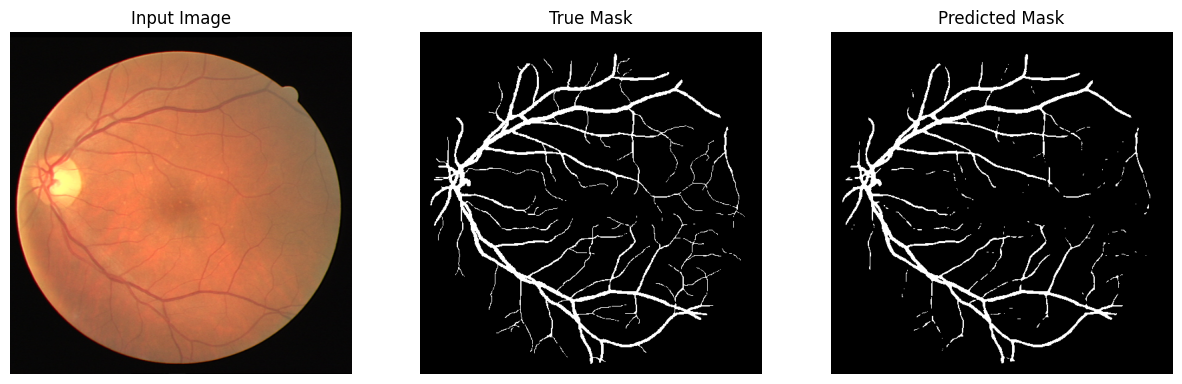


 Sample Output after 401 epochs

2/2 [==============================] - 2s 1s/step - loss: 0.0498 - accuracy: 0.9896 - f1_metric: 0.9409 - mcc_metric: 0.9354
Epoch 402/420
2/2 [==============================] - 1s 423ms/step - loss: 0.0497 - accuracy: 0.9895 - f1_metric: 0.9402 - mcc_metric: 0.9347
Epoch 403/420
2/2 [==============================] - 1s 437ms/step - loss: 0.0498 - accuracy: 0.9894 - f1_metric: 0.9400 - mcc_metric: 0.9345
Epoch 404/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0495 - accuracy: 0.9896 - f1_metric: 0.9412 - mcc_metric: 0.9358
Epoch 405/420
2/2 [==============================] - 1s 435ms/step - loss: 0.0494 - accuracy: 0.9895 - f1_metric: 0.9409 - mcc_metric: 0.9354
Epoch 406/420
2/2 [==============================] - 1s 439ms/step - loss: 0.0494 - accuracy: 0.9895 - f1_metric: 0.9403 - mcc_metric: 0.9348
Epoch 407/420
2/2 [==============================] - 1s 434ms/step - loss: 0.0491 - accuracy: 0.9896 - f1_metric: 0.9411 - mcc_metr

In [12]:
from sklearn.metrics import f1_score, matthews_corrcoef

# define optimizer
optim = keras.optimizers.Adam(0.0001)
bce = keras.losses.BinaryCrossentropy()

def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    return f1

def mcc_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    true_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip((1 - y_true) * y_pred, 0, 1)))
    false_negatives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * (1 - y_pred), 0, 1)))

    mcc = (true_positives * true_negatives - false_positives * false_negatives) / tf.keras.backend.sqrt(
        (true_positives + false_positives) * (true_positives + false_negatives) *
        (true_negatives + false_positives) * (true_negatives + false_negatives) + tf.keras.backend.epsilon())
    
    return mcc

# compile keras model with defined optimizer, loss, and metrics
model.compile(optim, bce, metrics=["accuracy", f1_metric, mcc_metric])
callback = DisplayCallback(train_dataset)
model.fit(
    train_dataset, 
    callbacks=[callback],
    epochs=420
)

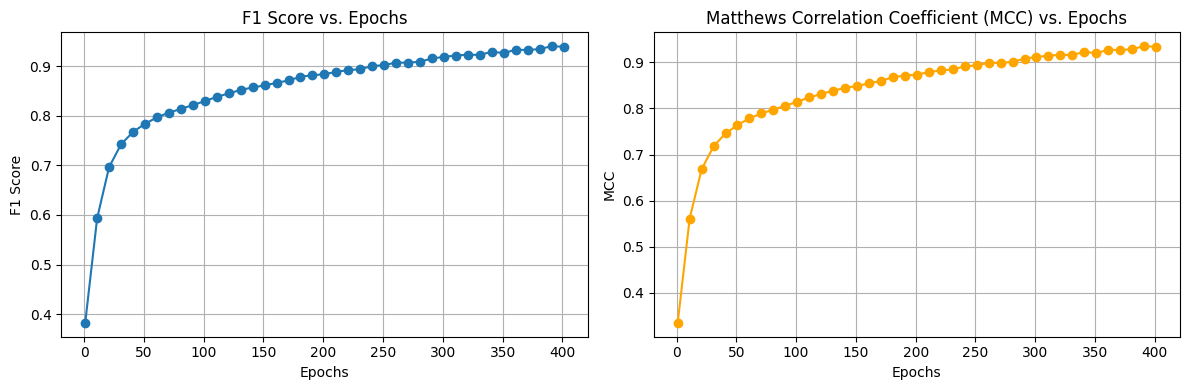

In [13]:


f1_scores = callback.f1_scores
mcc_scores = callback.mcc_scores

# Create a new list for x-axis representing each epoch
epochs = list(range(1, len(f1_scores) * 10 + 1, 10))[:len(f1_scores)]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, f1_scores, marker='o')  # Use the new epochs list
plt.title('F1 Score vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, mcc_scores, marker='o', color='orange')  # Use the new epochs list
plt.title('Matthews Correlation Coefficient (MCC) vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('MCC')
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 [==============================] - 1s 861ms/step


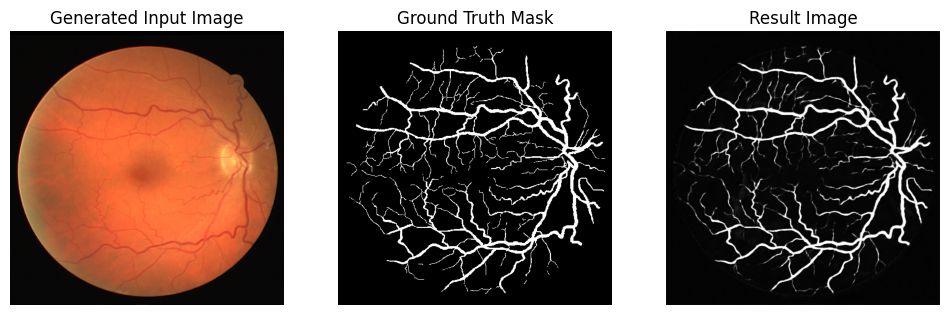

In [14]:
input_image=image[1]
ground_truth_mask=mask[1]
input_image = np.expand_dims(input_image, axis=0)

input_image = np.squeeze(input_image, axis=0)

# Plot the generated image and its ground truth mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Generated Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

# Add batch dimension to the image
input_image = np.expand_dims(input_image, axis=0)

enhanced_image = model.predict(input_image)[0]

plt.subplot(1, 3, 3)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Result Image')
plt.axis('off')

plt.show()